# Model Evaluation Notebook

This notebook evaluates the performance of the trained transformer model against baseline methods.

## Setup and Data Loading

In [ ]:
import sys

sys.path.append("..")

from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.keras_models as Models
import core
import os
import keras

# Configuration
if False:
    PLOTS_DIR = "plots/ToponiumInfusedTransformer/"
    MODEL_DIR = "models/mixed_model"
elif True:
    PLOTS_DIR = "plots/RegressionTransformer/"
    MODEL_DIR = "../models/regression_transformer_old/"
    PREDICTIONS_DIR = "predictions/RegressionTransformer_nu_flows_neutrino_only/"

else:
    PLOTS_DIR = "plots/RegressionTransformer_/"
    MODEL_DIR = "../models/regression_transformer_old/"


CONFIG_PATH = "../config/workspace_config.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 18})

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)

data_config = DataProcessor.load_from_npz(
    load_config.data_path["nominal"], max_events=4_00_000, event_numbers="odd"
)
X,y = DataProcessor.get_data()
del DataProcessor

2026-01-16 18:57:21.324785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768586241.348970 2906786 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768586241.357120 2906786 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768586241.376282 2906786 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768586241.376302 2906786 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768586241.376304 2906786 computation_placer.cc:177] computation placer alr

## Load Model and Setup Evaluator

In [ ]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation.reconstruction_evaluator as Evaluation
from core.reconstruction import (
    GroundTruthReconstructor,
    PerfectAssignmentReconstructor,
    CompositeNeutrinoComponentReconstructor,
)

reload(Evaluation)
reload(BaselineMethods)
ground_truth_assigner = GroundTruthReconstructor(data_config, use_nu_flows=True)
perfect_assigner = PerfectAssignmentReconstructor(
    data_config, neutrino_reco_name=r"Transformer $\nu$"
)
MODEL_DIR = "../models/regression_transformer/"
perfect_assigner.load_model(f"{MODEL_DIR}/model.keras")

prediction_manager = Evaluation.PredictionManager(
    [ground_truth_assigner, perfect_assigner], X, y
)

prediction_manager.save_predictions(os.path.join(PREDICTIONS_DIR, "odd_predictions/"))

evaluator = Evaluation.ReconstructionEvaluator(prediction_manager)

I0000 00:00:1768586364.022397 3235377 service.cc:152] XLA service 0x7f89c400c500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768586364.022426 3235377 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2026-01-16 18:59:24.285418: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-16 18:59:24.377335: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator keras_model_wrapper_3_1/met_input_transform_1/assert_equal_1/Assert/Assert
I0000 00:00:1768586365.289002 3235377 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1768586368.532503 3235377 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2026-01-16 19:00:21.747947: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert 


Computing binned accuracy quotients for truth_ttbar_mass...


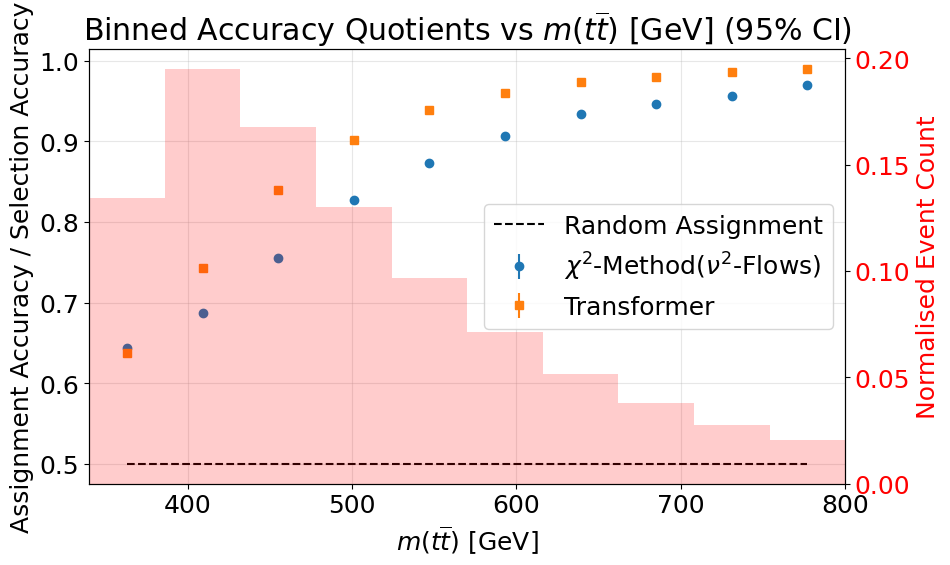

In [4]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_mass.pdf")

In [5]:
evaluator.save_accuracy_latex_table(
    n_bootstrap=100, confidence=0.95, save_dir=PLOTS_DIR
)

LaTeX table saved to plots/RegressionTransformer/reconstruction_accuracies_table.tex



Computing bootstrap confidence intervals...
$\chi^2$-Method($\nu^2$-Flows): 0.7393 [0.7385, 0.7404]
Transformer: 0.8130 [0.8120, 0.8139]


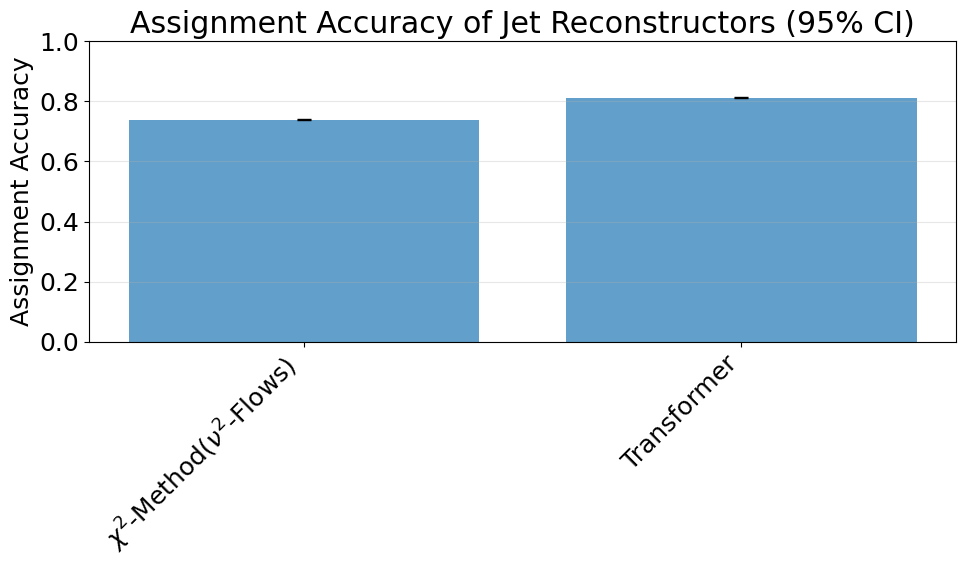

In [6]:
fig, ax = evaluator.plot_all_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing bootstrap confidence intervals...
$\chi^2$-Method($\nu^2$-Flows): 0.9234 [0.9231, 0.9238]
Transformer: 0.9568 [0.9560, 0.9572]


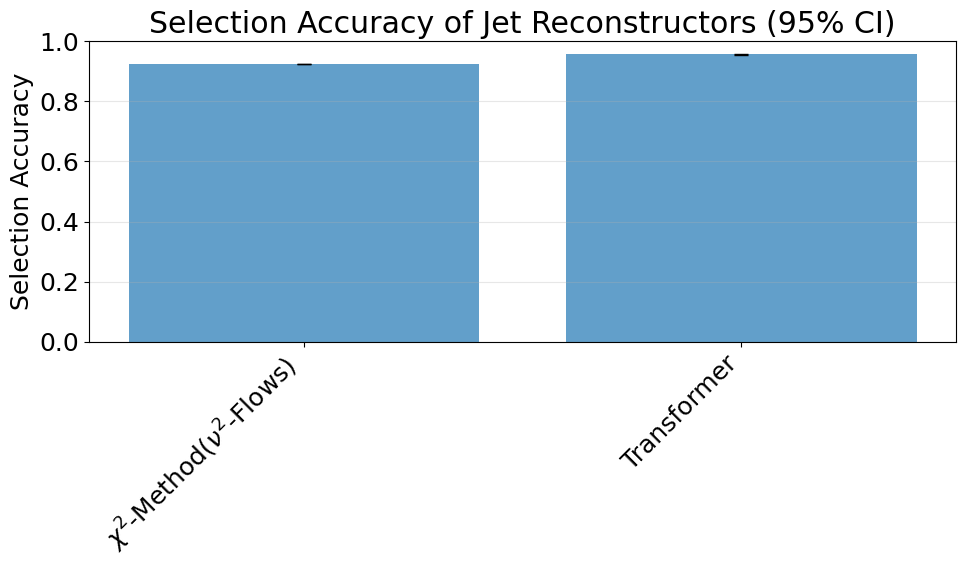

In [7]:
fig, ax = evaluator.plot_all_selection_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_selection_accuracies.pdf")


Computing binned accuracy for N_jets...


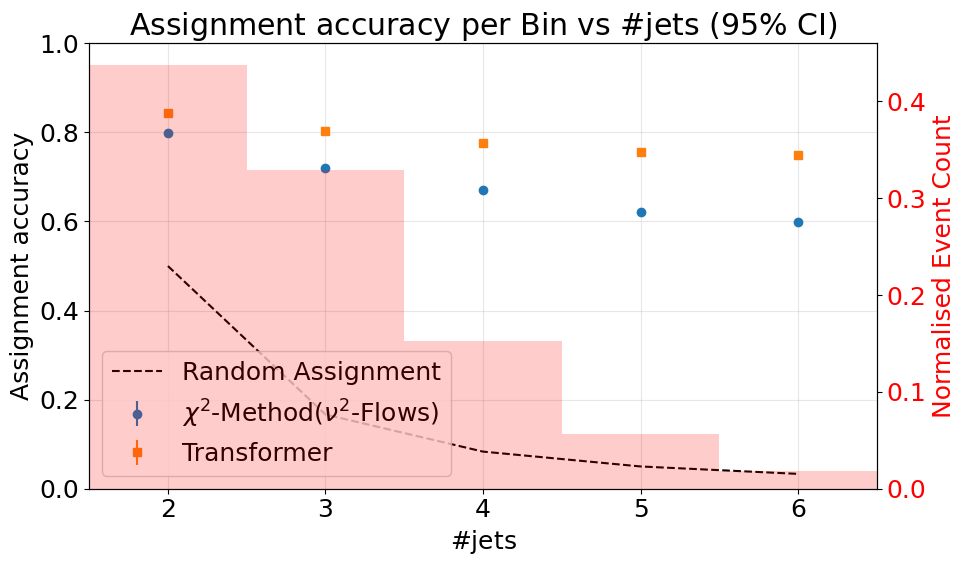

In [8]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")


Computing binned accuracy quotients for N_jets...


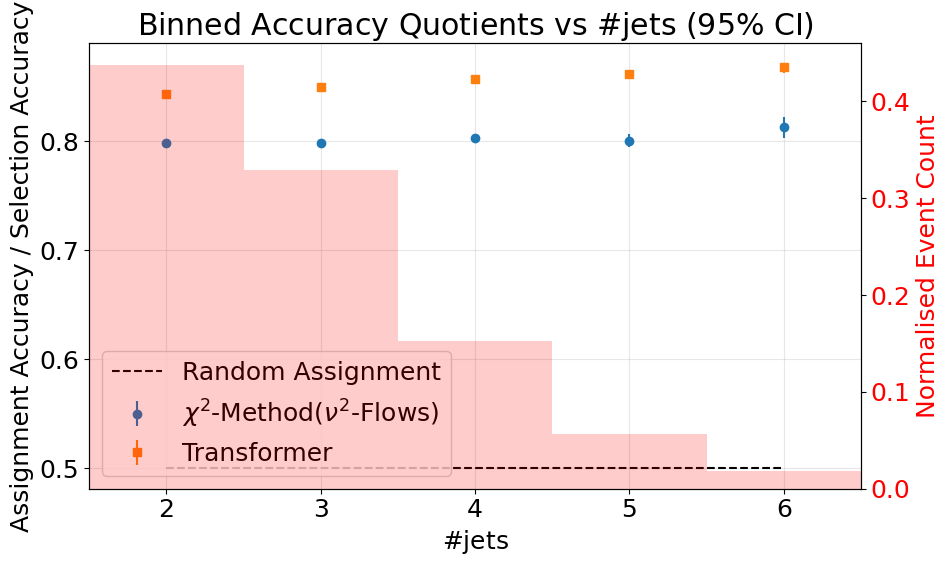

In [9]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.set_xlim(2, data_config.max_jets + 1)
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_quotients_N_jets.pdf")


Computing binned accuracy for truth_ttbar_mass...


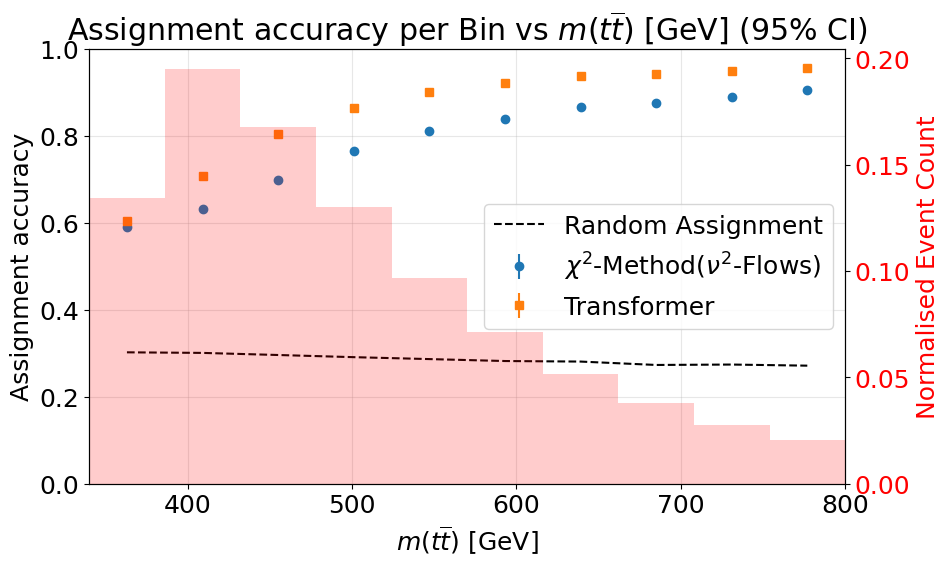

In [10]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_pt...


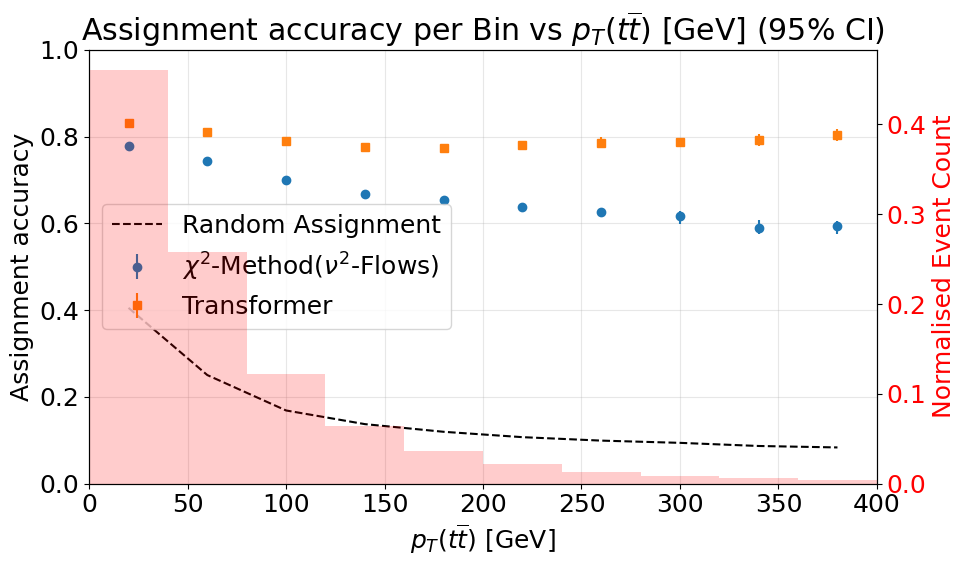

In [11]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned accuracy quotients for truth_ttbar_pt...


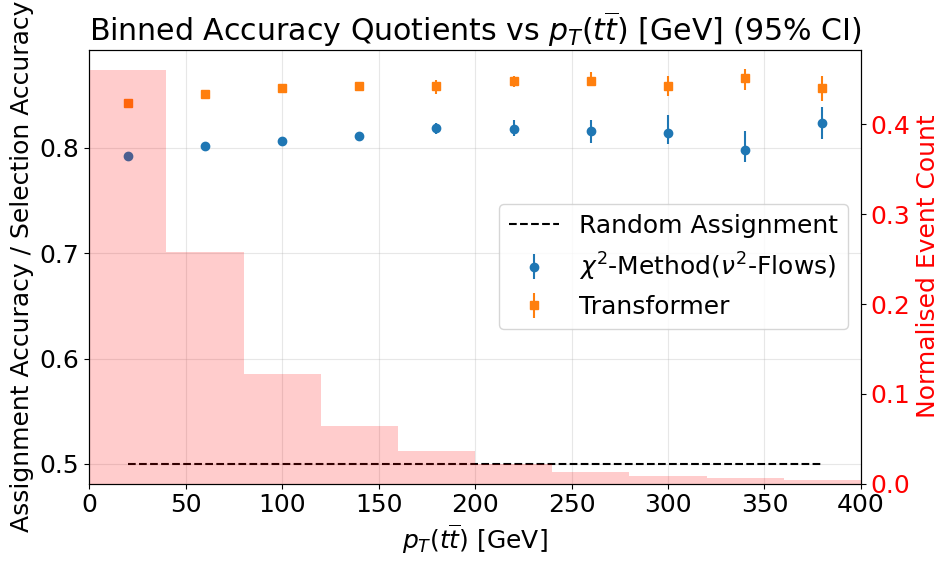

In [12]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_pT.pdf")


Computing binned accuracy for dR_l1l2...


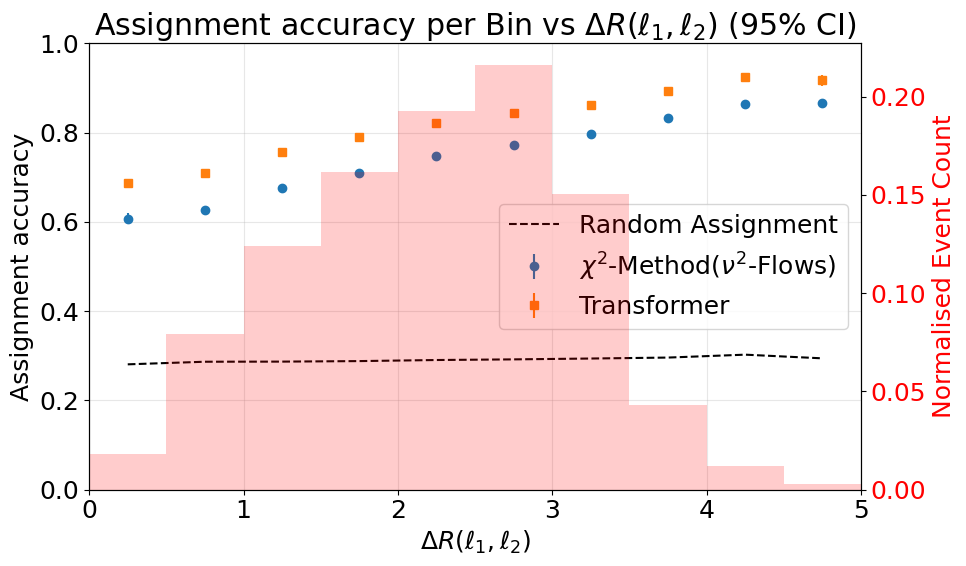

In [13]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="dR_l1l2",
    fancy_feature_label=r"$\Delta R(\ell_1,\ell_2)$",
    xlims=(0, 5),
    bins=10,
    n_bootstrap=10,
)
ax.set_xlim(0, 5)
fig.savefig(PLOTS_DIR + "binned_accuracy_dR_l1l2.pdf")


Computing binned accuracy for truth_ttbar_mass...


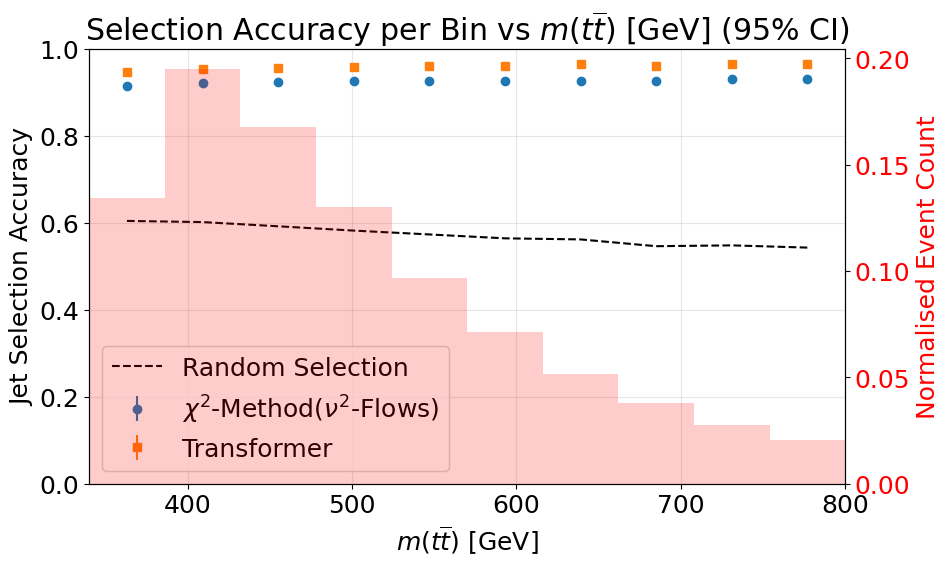

In [14]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_ttbar_mass.pdf")


Computing binned accuracy for N_jets...


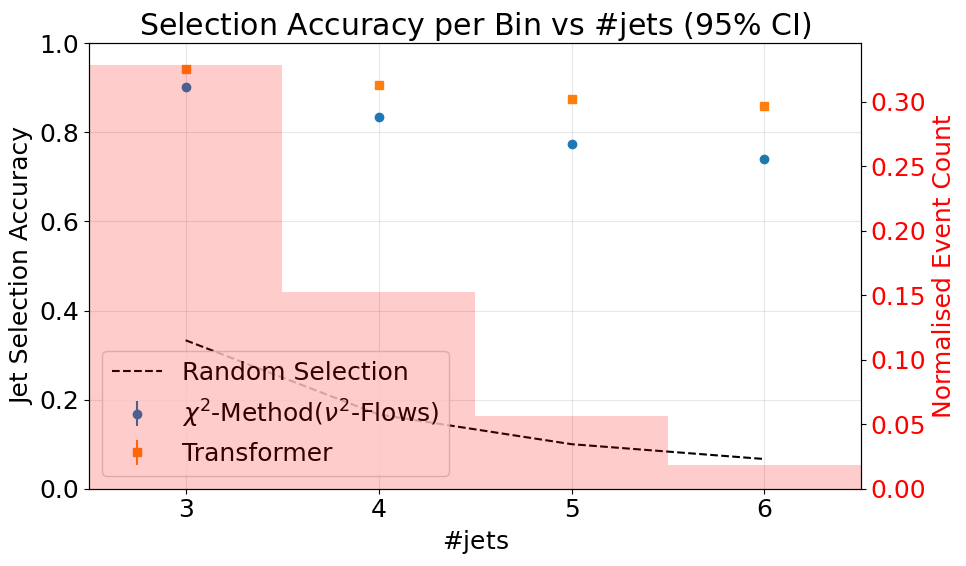

In [15]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(3, data_config.max_jets + 1),
    bins=data_config.max_jets - 2,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(3, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(3, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_N_jets.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


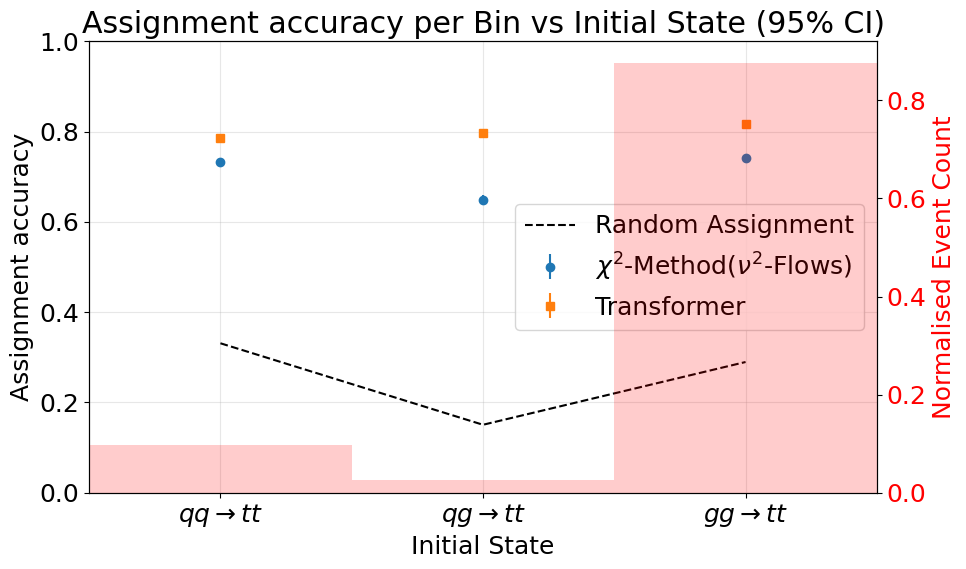

In [16]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


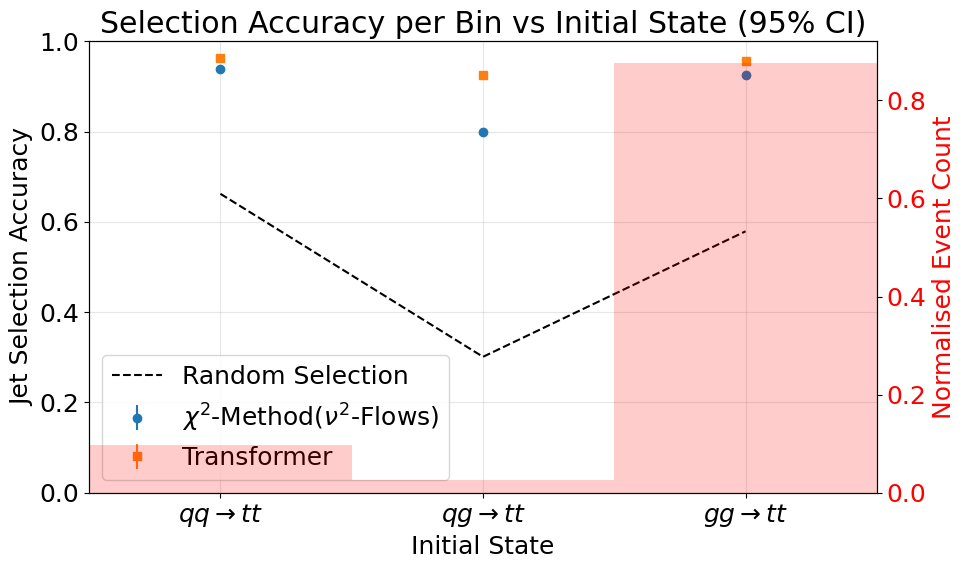

In [17]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_initial_state.pdf")


Computing binned accuracy quotients for truth_initial_parton_num_gluons...


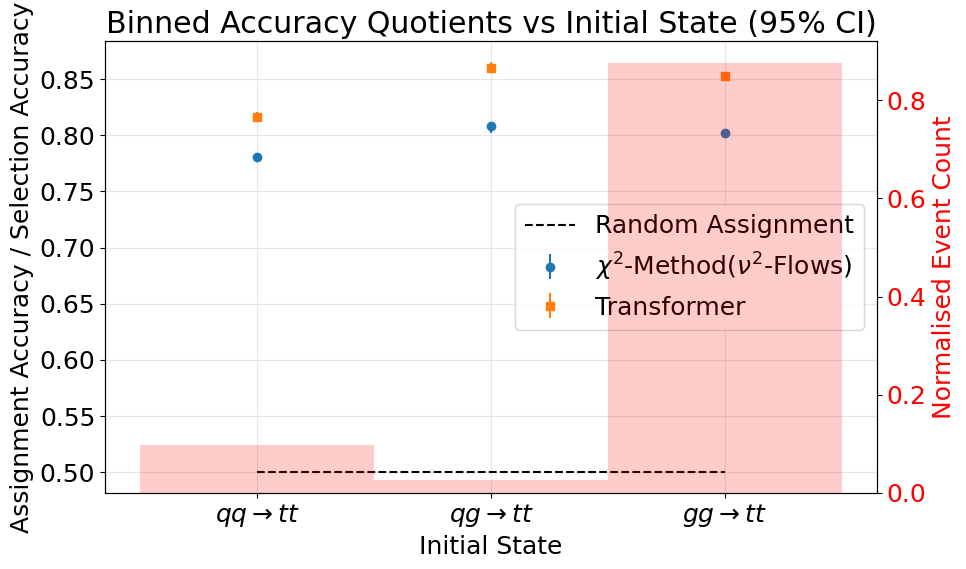

In [18]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_quotients_initial_state.pdf")

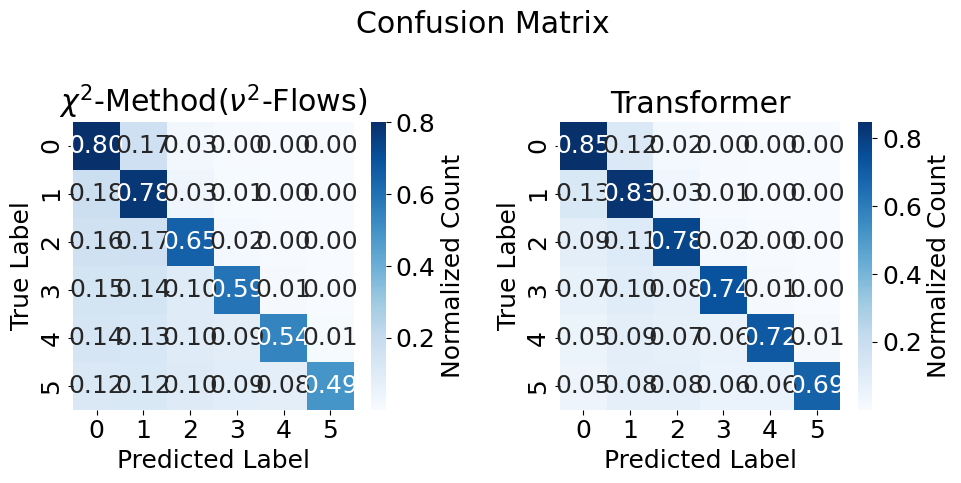

In [19]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

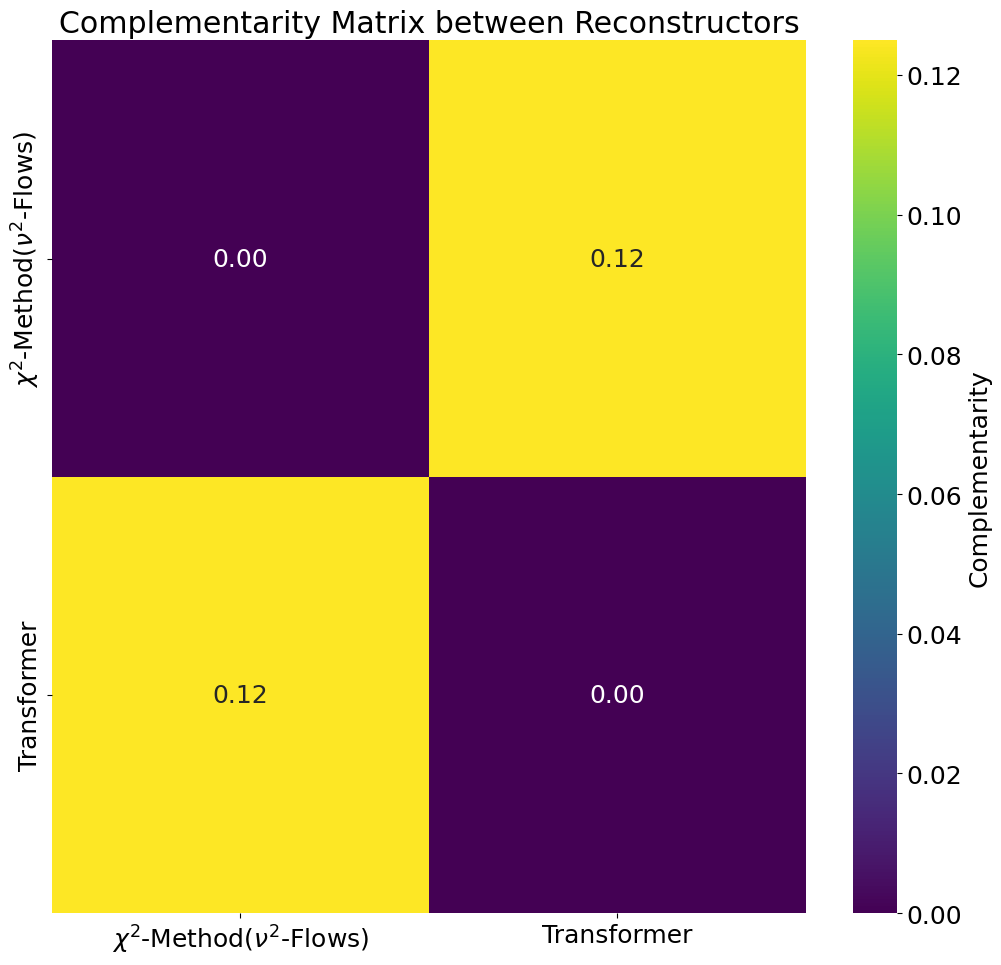

In [20]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(10.5, 10))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")